In [132]:
include("LazyMatrices.jl")
include("TurtleSearch.jl")
# using .LazyMatrices, .TurtleSearch
import .LazyMatrices as lm
import .TurtleSearch as tt

In [88]:
include("eom.jl")
import .GoldbergerWiseEoM as eom
# using .GoldbergerWiseEoM

In [26]:
using Plots, LaTeXStrings

In [75]:
function g2_m_perturb(l2, xrange, u=eom.u, k=eom.k, yₘ=eom.yₘ)
    g2s0 = exp10.(range(xrange..., 100))
    m2s0 = 4l2*(2k+u)*u^2/(3k)*(1-exp(2k*yₘ))/(1-exp((4k+2u)*yₘ)) * (1 .- (4k+2u) ./g2s0)
    # ms0 = sqrt.(m2s0)
    return g2s0, m2s0
end

g2_m_perturb (generic function with 4 methods)

In [142]:
function nextpose(poses, m)
    t = tt.Turtles(max(poses...))
    inds = tt.bisearch(t, m)
    xs = [m.xaxis(inds[1])]
    ys = [m.yaxis(inds[2])]
    while !isnothing(tt.next!(t, m))
        inds = tt.bisearch(t, m)
        push!(xs,m.xaxis(inds[1]))
        push!(ys,m.yaxis(inds[2]))
    end
    poses = tt.findfirstseed!(m, map(x->x+CartesianIndex(0,1), poses)...)
    return xs, ys, poses
end
function g2_m2_numerical(l2, xrange, yrange, u=eom.u, k=eom.k, φP=1e-1; xlogscaled = false, nSeeds = 1)
    paramsearch_g2_m2 = eom.paramsearch(l2=l2, φP=φP)
    m = lm.LazyMatrix(zeros(30,30), paramsearch_g2_m2, xrange, yrange, xlogscaled = xlogscaled)
    poses = tt.findfirstseed!(m, CartesianIndex(1, 1), CartesianIndex(1, 2))
    @assert !isnothing(poses) "no seed found"
    g2_m2 = []
    for i = 1:nSeeds
        g2s, m2s, poses = nextpose(poses, m)
        push!(g2_m2, (g2s, m2s))
    end
    return g2_m2
end

g2_m2_numerical (generic function with 4 methods)

In [77]:
function getφ(m2, l2, g2; FP=1., φP=1.)
    params = (m2, l2, g2)
    Fsol = eom.solveODE(FP, φP, params)
    eom.getφ(Fsol, params)
end

getφ (generic function with 1 method)

In [147]:
g2_m2 = g2_m2_numerical(1e-3, (0, 4), (-10, 10), eom.u, eom.k, 1e-2, nSeeds=1)

xs

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/packages/SciMLBase/zXEYU/src/integrator_interface.jl:536
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/packages/SciMLBase/zXEYU/src/integrator_interface.jl:536


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/packages/SciMLBase/zXEYU/src/integrator_interface.jl:536
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/packages/SciMLBase/zXEYU/src/integrator_interface.jl:536
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/packages/SciMLBase/zXEYU/src/integrator_interface.jl:536
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/packages/SciMLBase/zXEYU/src/integrator_interface.jl:536
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/packages/SciMLBase/zXEYU/src/integrator_interface.jl:536
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/packages/SciMLBase/zXEYU/src/integrator_interface.jl:536
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/packages/SciMLBase/zXEYU/src/integrator_interface.jl:536
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/outk/.julia/p

1-element Vector{Any}:
 ([0.0, 0.13793103448275862, 0.27586206896551724, 0.41379310344827586, 0.5517241379310345, 0.6896551724137931, 0.8275862068965517, 0.9655172413793104, 1.103448275862069, 1.2413793103448276  …  2.7586206896551726, 2.896551724137931, 3.0344827586206895, 3.1724137931034484, 3.310344827586207, 3.4482758620689653, 3.586206896551724, 3.7241379310344827, 3.8620689655172415, 4.0], [0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242  …  0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242, 0.7698006465517242])

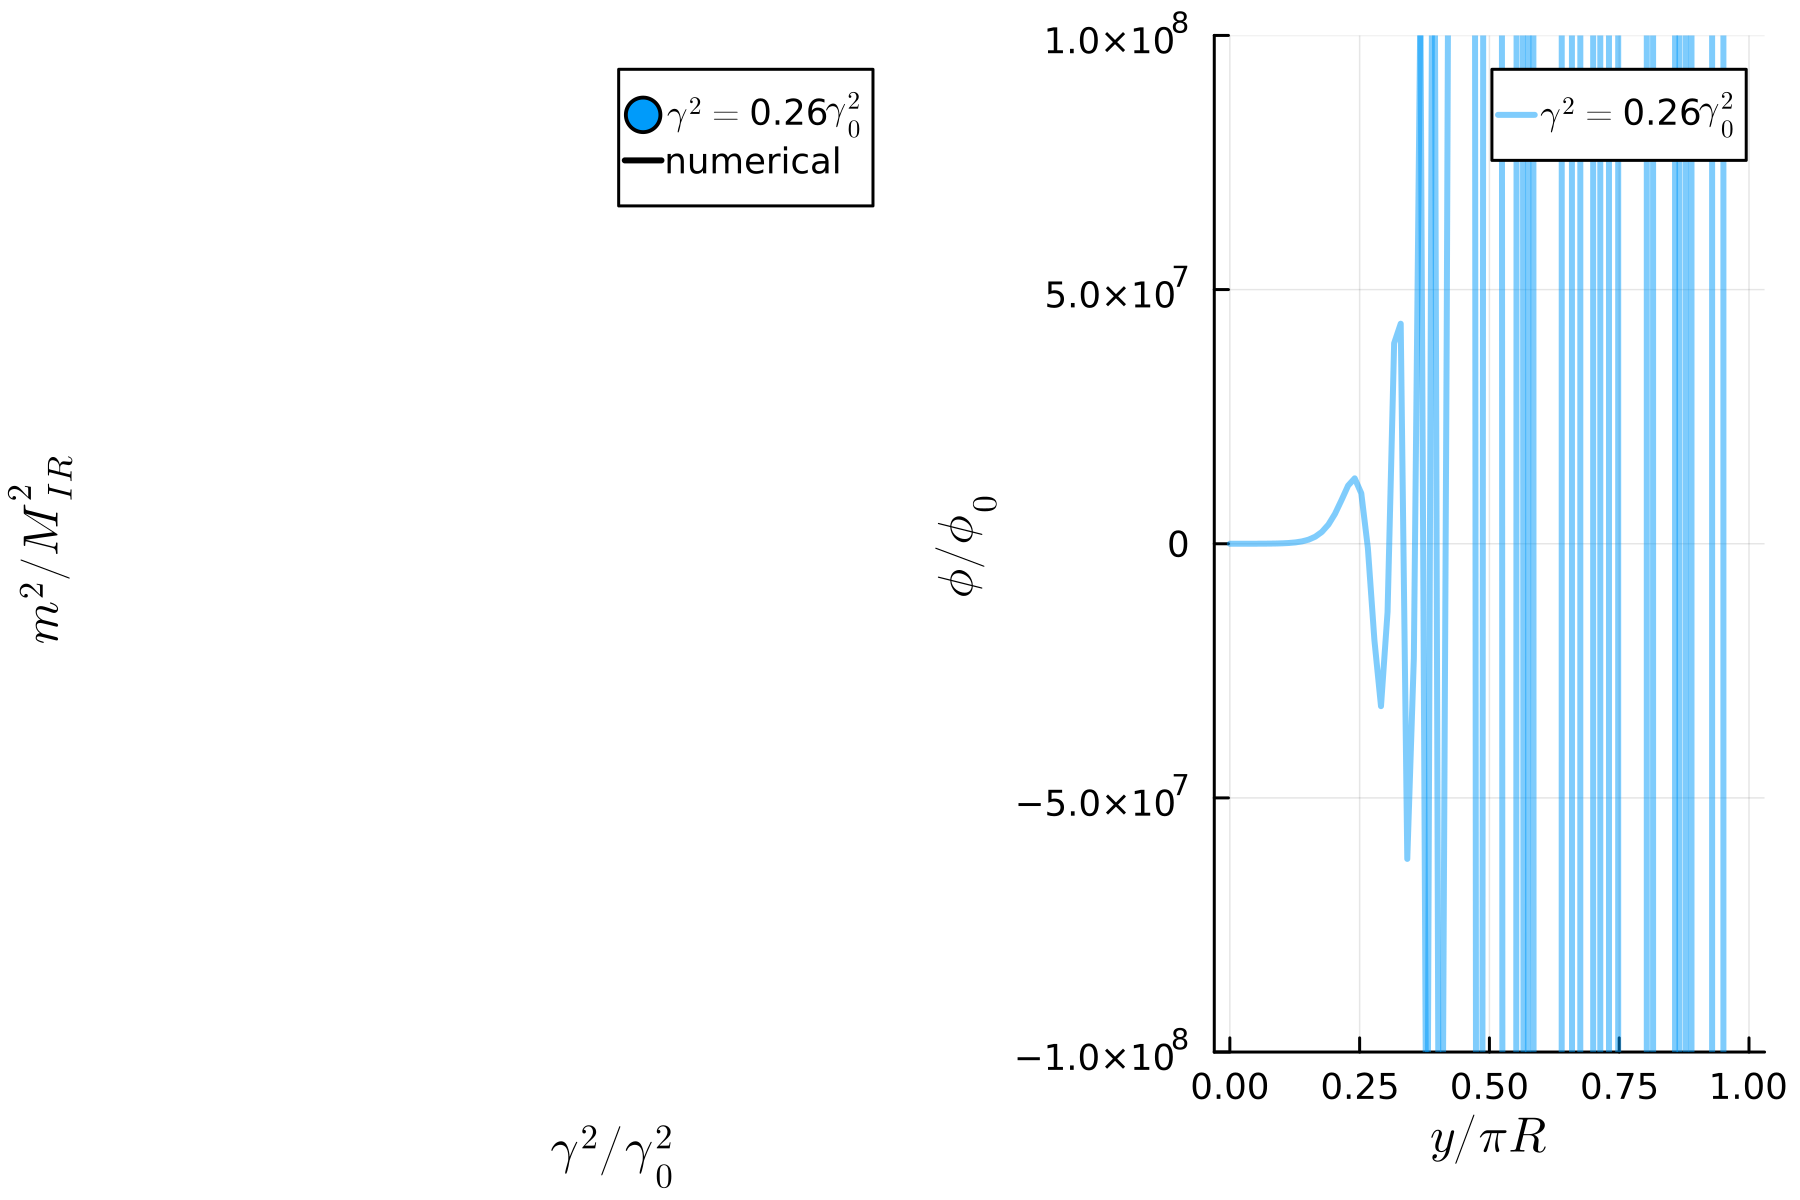

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/outk/.julia/packages/PlotUtils/bZEEj/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/outk/.julia/packages/PlotUtils/bZEEj/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots /Users/outk/.julia/packages/Plots/9Q9pN/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/outk/.julia/packages/PlotUtils/bZEEj/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/outk/.julia/packages/PlotUtils/bZEEj/src/ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots /Users/outk/.julia/packages/Plots/9Q9pN/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/outk/.julia/packages/PlotUtils/bZEEj/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/outk/.julia/packages/PlotUtils/bZEEj/src/ticks.jl:191
┌ Warning: No strict ticks found

In [150]:
f1 = scatter()
f2 = plot(xlabel = L"y/\pi R", ylabel = L"\phi/\phi_0")
for (g2s, m2s) in g2_m2
    inds = findall(x-> 0.25eom.γ²₀ < x < 4eom.γ²₀, g2s)[1:2:end]
    
    for i in inds
        scatter!(f1, [g2s[i]/eom.γ²₀], [m2s[i]/eom.M_IR^2], label = L"\gamma^2="*string(round(g2s[i]/eom.γ²₀, digits=2))*L"\gamma_0^2")
        φ(x) = getφ(m2s[i], 1e-3, g2s[i])(x)
        plot!(f2, x-> (φ(π*x)+eom.ϕ0(π*x))/eom.ϕP, range(0,1,80), label = L"\gamma^2="*string(round(g2s[i]/eom.γ²₀, digits=2))*L"\gamma_0^2", lw=2, alpha=0.5, ylim=(-1e8,1e8))
    end
end
plot!(f1, g2_m2[1]./[eom.γ²₀, eom.M_IR^2]..., label = "numerical", xlabel = L"\gamma^2/\gamma^2_0", ylabel = L"m^2/M_{IR}^2", legend = :topright, xaxis=:log10, lw=2, c=:black)
# plot!(f1, g2_m[2]./[eom.γ²₀, eom.M_IR]..., label = nothing, lw=2, c=:black)
# plot!(f1, g2_m_perturb(1e-3, (log10(eom.γ²₀)*(1+1e-3), 4))./[eom.γ²₀, eom.M_IR]..., label = "perturbative", lw=2, c=:black, ls=:dash)
f = plot!(f1, f2, layout = (1,2), dpi=300)
display(f)

In [64]:
let 
    function f!(x)
        x = x+1
    end
    @show x = 1
    @show f!(x)
    @show x
end

x = 1 = 1
f!(x) = 2
x = 1

1

在 Julia 中，如果你想要在函数内部改变变量的值，你需要使用特殊的数据类型，如 Array 或者 Dict。对于基本数据类型（如 Int，Float），Julia 默认是不允许在函数内部改变它们的值的。但是，你可以通过返回新的值来实现这个效果。

以下是一个例子：



In [ ]:
let 
    function f!(x)
        x[1] = x[1] + 1
    end
    x = [1]
    @show x[1]
    f!(x)
    @show x[1]
end



在这个例子中，我们使用了一个单元素的 Array 来存储 x 的值。然后我们在函数 `f!` 中改变了这个 Array 的值。这样，函数 `f!` 就能够“就地”改变 x 的值了。